In [1]:
#@ Initialization:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install trax

In [3]:
#@ Downloading the Libraries and Dependencies. 
# !pip install -q -U trax                         # Downloading the Trax.
# nltk.download("punkt")
import pandas as pd
import numpy as np
import os
import nltk
import trax
from trax import layers as tl
from trax.supervised import training
from trax.fastmath import numpy as fastnp
import random
from collections import defaultdict
from functools import partial

random.seed(111)

In [9]:
data=pd.read_csv('/content/gdrive/MyDrive/sLSTM_QQP/Questions.csv')#download and save the data from Quora QQP site

#@ Inspecting the Data:
print(f"Number of Questions Pairs: {len(data)}")
data.head(10)                                                        # Inspecting the DataFrame.

Number of Questions Pairs: 404351


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [ ]:
!pip install distance

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [11]:
df = pd.read_csv('/content/gdrive/MyDrive/sLSTM_QQP/Questions.csv')

print("Number of data points:",df.shape[0])


Number of data points: 404351


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


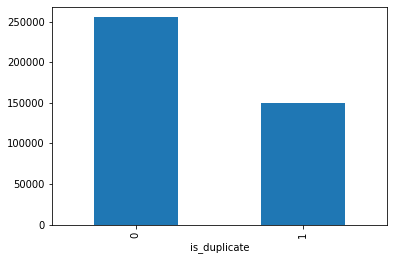

In [13]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [14]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404351


In [ ]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

<h3>Number of unique questions </h3>



In [16]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 789801

Number of unique questions that appear more than one time: 13698 (1.7343609339567814%)

Max number of times a single question is repeated: 50



In [ ]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>Checking for Duplicates </h3>

In [18]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions -3


<h3> Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 50



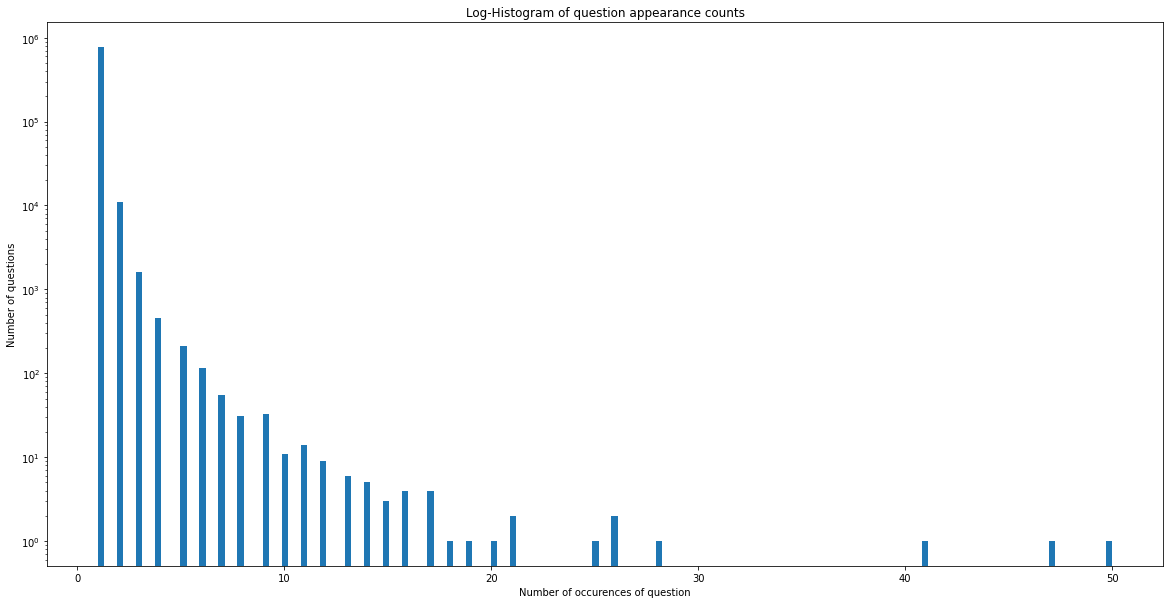

In [19]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> Checking for NULL values </h3>

In [20]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105796  105796  209841  209842    How can I develop android app?   
201871  201871  398348  398349  How can I create an Android app?   
363416  363416  711434  711435                               NaN   

                                                question2  is_duplicate  
105796                                                NaN             0  
201871                                                NaN             0  
363416  My Chinese name is Haichao Yu. What English na...             0  


In [21]:
#:\- There are two rows with null values in question2 
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []




Let us now construct a few features like:

  *  freq_qid1 = Frequency of qid1's
  *  freq_qid2 = Frequency of qid2's
  *  q1len = Length of q1
  *  q2len = Length of q2
  *  q1_n_words = Number of words in Question 1
  *  q2_n_words = Number of words in Question 2
  *  word_Common = (Number of common unique words in Question 1 and Question 2)
  *  word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
  *  word_share = (word_common)/(word_Total)
  * freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
  *  freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2



In [22]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


:<h3> Analysis of some of the extracted features </h3>

In [23]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 60
Number of Questions with minimum length [question2] : 25


<h4> Feature: word_share </h4>

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



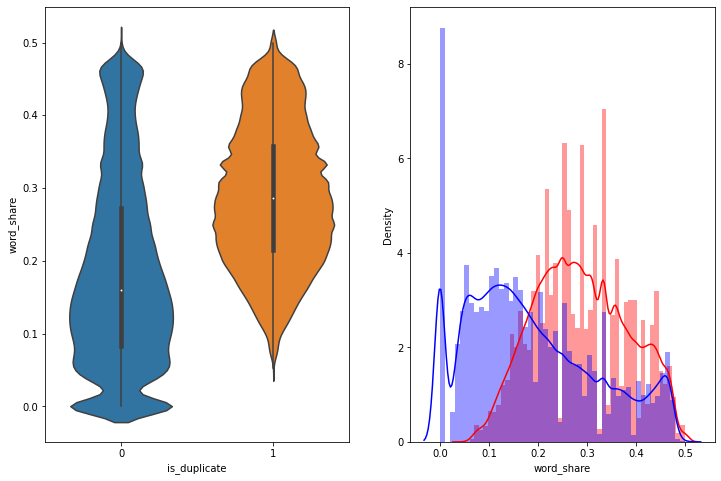

In [24]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

<h4> Feature: word_Common </h4>


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



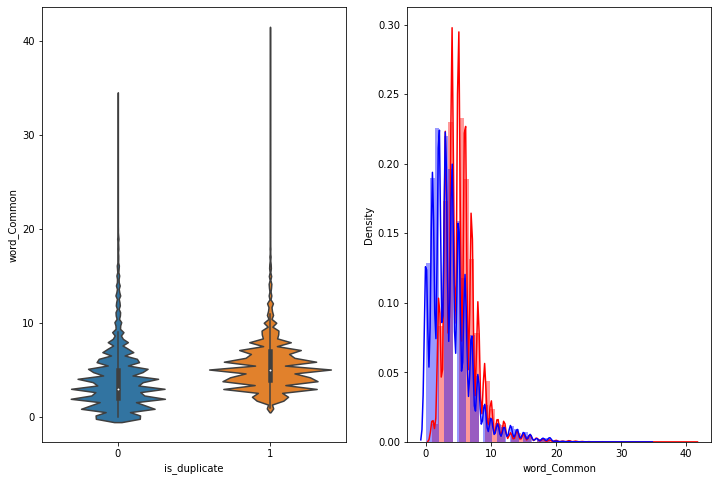

In [25]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

In [11]:
#@ Processing the Data:
N_train = 300000                                               
N_test = 10240                                                 
data_train = data[:N_train]                                                    # Training pairs.
data_test = data[N_train:N_train+N_test]                                       # Test pairs.
del(data)                                                                      # Removing.

#@ Inspecting the Data:
print(f"Training Set: {len(data_train)} and Test Set: {len(data_test)}")

#@ Selecting the Question Pairs for Training:
train_idx = (data_train["is_duplicate"] == 1).to_numpy()
train_idx = [i for i,x in enumerate(train_idx) if x]
print(f"Number of Duplicate Questions: {len(train_idx)}")
print(f"Indexes of first Duplicate Questions: {train_idx[:10]}")

Training Set: 49848 and Test Set: 0
Number of Duplicate Questions: 18593
Indexes of first Duplicate Questions: [5, 7, 11, 12, 13, 15, 16, 18, 20, 29]


In [12]:
#@ Inspecting the Duplicate Questions:
print(data_train["question1"][20])                                 # Index 20 has Duplicate Questions pairs.
print(data_train["question2"][20])                                 # Index 20 has Duplicate Questions pairs.
print("Index 20 is duplicate:", data_train["is_duplicate"][20])

Why do rockets look white?
Why are rockets and boosters painted white?
Index 20 is duplicate: 1.0


**Preparing the Data**

In [34]:
len(data_train)

49848

In [31]:
#@ Preparing the Data: Training the Model:
Q1_train_words = np.array(data_train["question1"][train_idx])
Q2_train_words = np.array(data_train["question2"][train_idx])

#@ Preparing the Data: Evaluating the Model:
Q1_test_words = np.array(data_test["question1"])
Q2_test_words = np.array(data_test["question2"])
y_test = np.array(data_test["is_duplicate"])

# #@ Inspecting the Data:
print("TRAINING QUESTIONS:\n")
print("Question 1:", Q1_train_words[7])
print("Question 2:", Q2_train_words[7], "\n")



TRAINING QUESTIONS:

Question 1: Why are so many Quora users posting questions that are readily answered on Google?
Question 2: Why do people ask Quora questions which can be answered easily by Google? 



In [23]:
# print("TESTING QUESTIONS:\n")
print("Question 1:", Q1_test_words[7])
print("Question 2:", Q2_test_words[7], "\n")
print("Inspecting Testing pairs is duplicate:", y_test[0])

0

In [28]:
len(Q1_train_words)

18593

In [27]:
Q1_train_words

array(['Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?',
       'How can I be a good geologist?',
       'How do I read and find my YouTube comments?', ...,
       'Why do people use Quora when we already have google?',
       'What was the significance of the battle of Somme, and how did this battle compare and contrast to the Battle of Riyadh?',
       'Do any animals have empathy?'], dtype=object)

**Preparing the Data**


In [ ]:
import nltk
nltk.download('punkt')

In [38]:
#@ Preparing the Data:
Q1_train = np.empty_like(Q1_train_words)                                # Creating new Training array.
Q2_train = np.empty_like(Q2_train_words)                                # Creating new Training array.
Q1_test = np.empty_like(Q1_test_words)                                  # Creating new Test array.
Q2_test = np.empty_like(Q2_test_words)                                  # Creating new Test array.

#@ Building Vocabulary with Training Dataset:
vocab = defaultdict(lambda: 0)
vocab["<PAD>"] = 1
for idx in range(len(Q1_train_words)):
  Q1_train[idx] = nltk.word_tokenize(Q1_train_words[idx])               # Tokenizing the Training Set.
  Q2_train[idx] = nltk.word_tokenize(Q2_train_words[idx])               # Tokenizing the Training Set.
  q = Q1_train[idx] + Q2_train[idx]
  for word in q:
    if word not in vocab:
      vocab[word] = len(vocab) + 1
print("The length of the Vocabulary is:", len(vocab))

#@ Testing Dataset:
for idx in range(len(Q1_test_words)):
  Q1_test[idx] = nltk.word_tokenize(Q1_test_words[idx])                 # Tokenizing the Test Set.
  Q2_test[idx] = nltk.word_tokenize(Q2_test_words[idx])                 # Tokenizing the Test Set.

#@ Inspecting the Final Prepared Dataset:
print("Training Set is reduced to:", len(Q1_train))
print("Test Set is:", len(Q1_test))

The length of the Vocabulary is: 16109
Training Set is reduced to: 18593
Test Set is: 0


**Preparing the Data**


In [40]:
#@ Preparing the Data:

#@ Converting Questions pairs to array of Integers:
for i in range(len(Q1_train)):
  Q1_train[i] = [vocab[word] for word in Q1_train[i]]
  Q2_train[i] = [vocab[word] for word in Q2_train[i]]

#@ Converting Questions pairs to array of Integers:
for i in range(len(Q1_test)):
  Q1_test[i] = [vocab[word] for word in Q1_test[i]]
  Q2_test[i] = [vocab[word] for word in Q2_test[i]]

#@ Inspecting the Encoded Data:
print("Question in the Training Set:")                           # Inspecting the Training Set.
print(Q1_train_words[7], "\n")
print("Encoded Version:")
print(Q1_train[7], "\n")
print("Question in the Test Set:")                               # Inspecting the Test Set.
print(Q1_test_words[7], "\n")
print("Encoded Version:")
print(Q1_test[7], "\n")

#@ Splitting the Training Set into Training and Validation Dataset:
split = int(len(Q1_train) * 0.8)
train_Q1, train_Q2 = Q1_train[:split], Q2_train[:split]                        # Split for Training set.
val_Q1, val_Q2 = Q1_train[split:], Q2_train[split:]                            # Split for Validation set.
print(f"Total numbers of questions pairs: {len(Q1_train)}")              
print(f"The length of Training set: {len(train_Q1)}")                          # Length of Final Training set.
print(f"The length of Validation set: {len(val_Q1)}")                          # Length of Final Validation set.

Question in the Training Set:
Why are so many Quora users posting questions that are readily answered on Google? 

Encoded Version:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

Total numbers of questions pairs: 18593
The length of Training set: 14874
The length of Validation set: 3719


**Data Generator**


In [41]:
#@ Data Generator:
def data_generator(Q1, Q2, batch_size, pad=1, shuffle=True):
  """ Generator Function that yields the Batches of Data. """
  #@ Initializing the Dependencies:
  input1, input2 = [], []
  idx = 0
  len_q = len(Q1)
  question_index = [*range(len_q)]
  if shuffle:
    random.shuffle(question_index)
  
  while True:
    if idx >= len_q:
      idx = 0
      if shuffle:
        random.shuffle(question_index)
    #@ Getting the Questions pairs in Index positions:
    q1 = Q1[question_index[idx]]
    q2 = Q2[question_index[idx]]
    idx += 1
    #@ Adding the Data:
    input1.append(q1)
    input2.append(q2)
    if len(input1) == batch_size:
      max_len = max(max([len(q) for q in input1]),
                    max([len(q) for q in input2]))
      max_len = 2**int(np.ceil(np.log2(max_len)))
      b1, b2 = [], []
      for q1, q2 in zip(input1, input2):
        q1 = q1 + [pad] * (max_len - len(q1))                         # Adding pad to q1 until it reaches max length.
        q2 = q2 + [pad] * (max_len - len(q2))                         # Adding pad to q2 until it reaches max length.
        b1.append(q1)
        b2.append(q2)
      yield np.array(b1), np.array(b2)
      input1, input2 = [], []                                         # Resetting the Batches.

#@ Inspecting the Example of Data Generator:
res1, res2 = next(data_generator(train_Q1, train_Q2, batch_size=2))
print(f"First Questions:\n{res1}")
print(f"\nSecond Questions:\n{res2}")

First Questions:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]

Second Questions:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


**Siamese Neural Network**


In [42]:
#@ Siamese Neural Network using Trax:
def Siamese(vocab_size=len(vocab), d_model=128, mode="train"):
  """ Returns a Siamese Model. """
  #@ Normalizing the Vectors for L2 Normalization:
  def normalize(x):
    return x / fastnp.sqrt(fastnp.sum(x*x, axis=-1, keepdims=True))
  #@ Preparing the Model:
  processor = tl.Serial(                                                  # Returns one hot Vector.
      tl.Embedding(vocab_size=vocab_size, d_feature=d_model),             # Adding Embedding Layer.
      tl.LSTM(n_units=d_model),                                           # Adding the LSTM Layer.
      tl.Mean(axis=1),                                                    # Mean over Columns in Neural Networks.
      # tl.Dense(n_units=vocab_size),                                     # Adding a Dense Layer.
      tl.Fn("Normalize", lambda x: normalize(x))                          # Adding the Normalizing Function.
  )
  #@ Running the Model in parallel:
  model = tl.Parallel(processor, processor)
  return model

#@ Setting up Siamese Neural Network Model:
model = Siamese()
print(model)                                                              # Inspecting the Model.

Parallel_in2_out2[
  Serial[
    Embedding_32217_128
    LSTM_128
    Mean
    Normalize
  ]
  Serial[
    Embedding_32217_128
    LSTM_128
    Mean
    Normalize
  ]
]


**Triplet Loss**
The Triplet Loss involves a Baseline or Anchor Input, which is contrasted with the Positive or Truthy Input as well as a Negative or Falsy Input. The goal is to reduce the distance between the Anchor Input and the Positive Input, while simultaneously increasing the distance between the Anchor Input and the Negative Input. The Triplet Loss comprises two components: one that employs the mean of all non-duplicates and another that incorporates the Closest Negative.


In [43]:
#@ Triplet Loss Function:
def TripletLossFn(v1, v2, margin=0.25):
  """ Custom Loss Function. """
  scores = fastnp.dot(v1, v2.T)                                                       # Calculating the dot product of two batches.
  batch_size = len(scores)                                                            # Calculating the new batch size.
  positive = fastnp.diagonal(scores)                                                  # Getting positive diagonal entries in scores.
  negative_without_positive = scores - 2.0 * fastnp.eye(batch_size)
  closest_negative = negative_without_positive.max(axis=1)                            # Taking row by row max.
  negative_zero_on_duplicate = scores * (1.0 - fastnp.eye(batch_size))
  mean_negative = fastnp.sum(negative_zero_on_duplicate, axis=1)/(batch_size - 1)
  triplet_loss1 = fastnp.maximum(0, margin - positive + closest_negative)
  triplet_loss2 = fastnp.maximum(0, margin - positive + mean_negative)
  triplet_loss = fastnp.mean(triplet_loss1 + triplet_loss2)
  return triplet_loss

#@ Triplet Loss:
def TripletLoss(margin=0.25):
  triplet_loss_fn = partial(TripletLossFn, margin=margin)
  return tl.Fn("TripletLoss", triplet_loss_fn)

**Training the Model**


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [46]:
#@ Preparing the Data:
batch_size = 256
train_generator = data_generator(train_Q1, train_Q2, batch_size, vocab["<PAD>"])
val_generator = data_generator(val_Q1, val_Q2, batch_size, vocab["<PAD>"])

#@ Training the Model:
lr_schedule = trax.lr.warmup_and_rsqrt_decay(400, 0.01)
def train_model(Siamese, TripletLoss, lr_schedule, train_generator=train_generator,
                val_generator=val_generator, output_dir="/content/gdrive/MyDrive/sLSTM_QQP/model/"):
  """ Training the Siamese Model. """
  output_dir = os.path.expanduser(output_dir)
  
  #@ Training:
  train_task = training.TrainTask(
      labeled_data = train_generator,                                                   # Using Train Generator.
      loss_layer = TripletLoss(),                                                       # Using Triplet Loss Function.
      optimizer = trax.optimizers.Adam(0.001),                                          # Using Adam Optimizer.
      lr_schedule = lr_schedule                                                         # Using Trax Multifactor Schedule Function.
  )
  #@ Evaluating:
  eval_task = training.EvalTask(
      labeled_data = val_generator,                                                     # Using Validation Generator.
      metrics = [TripletLoss()],                                                        # Instantiating the Objects for Evaluation.
      n_eval_batches = 3
  )
  #@ Training the Model:
  training_loop = training.Loop(                                                        # Training the Model
      Siamese(),                                                                        # Siameses Neural Networks.
      train_task, eval_tasks = eval_task,
      output_dir = output_dir
  )
  return training_loop

#@ Training the Model:
training_loop = train_model(Siamese, TripletLoss, lr_schedule)
training_loop.run(1000)                                                                  # Training the Model for 1000 Epochs.


Step      1: Total number of trainable weights: 4255360
Step      1: Ran 1 train steps in 3.74 secs
Step      1: train TripletLoss |  0.49999356
Step      1: eval  TripletLoss |  0.49999061

Step    100: Ran 99 train steps in 75.72 secs
Step    100: train TripletLoss |  0.49968684
Step    100: eval  TripletLoss |  0.49922419

Step    200: Ran 100 train steps in 69.86 secs
Step    200: train TripletLoss |  0.48584667
Step    200: eval  TripletLoss |  0.48011306

Step    300: Ran 100 train steps in 73.17 secs
Step    300: train TripletLoss |  0.48056397
Step    300: eval  TripletLoss |  0.47524858

Step    400: Ran 100 train steps in 70.01 secs
Step    400: train TripletLoss |  0.48131034
Step    400: eval  TripletLoss |  0.47194600

Step    500: Ran 100 train steps in 72.81 secs
Step    500: train TripletLoss |  0.48071545
Step    500: eval  TripletLoss |  0.47255158

Step    600: Ran 100 train steps in 75.93 secs
Step    600: train TripletLoss |  0.48112512
Step    600: eval  TripletL

**Model Evaluation**


In [47]:
#@ Loading the Saved Model:
model = Siamese()
model.init_from_file("/content/gdrive/MyDrive/sLSTM_QQP/model/model.pkl.gz")

(((array([[ 0.07939621, -0.26573476,  0.12223061, ...,  0.20898676,
            0.08737288,  0.09720153],
          [-0.05256308, -0.00916104, -0.01397985, ..., -0.00953903,
           -0.06310194, -0.04759074],
          [-0.09630544,  0.03619412, -0.04607287, ..., -0.04351188,
            0.00881127, -0.04501174],
          ...,
          [ 0.10142217,  0.03181137, -0.031425  , ...,  0.01104168,
            0.09128119, -0.10938584],
          [-0.11721876,  0.03370195, -0.10168431, ..., -0.14078984,
           -0.09199182, -0.14388826],
          [ 0.01887889, -0.02125471,  0.08437227, ..., -0.02662073,
           -0.0789435 , -0.04087951]], dtype=float32),
   (((), ((), ())),
    ((array([[-0.04034491, -0.02404574,  0.02646142, ...,  0.07891188,
               0.05295587, -0.0104585 ],
             [-0.07388708, -0.06453328, -0.05944435, ..., -0.07094423,
              -0.07878357, -0.05323666],
             [ 0.05420591,  0.07177616, -0.0006992 , ...,  0.06935316,
               0.

In [ ]:
#@ Model Evaluation: 
def classify(test_Q1, test_Q2, y, threshold, model, vocab, data_generator=data_generator, batch_size=64):
  """ Function to test the Accuracy of the Model. """
  accuracy = 0                                                                               # Initializing the Accuracy.
  for i in range(0, len(test_Q1), batch_size):
    q1, q2 = next(data_generator(test_Q1[i:i+batch_size], test_Q2[i:i+batch_size],
                                 batch_size, vocab["<PAD>"], shuffle=False))
    y_test = y[i:i+batch_size]                                                               # Using batch size of actual output target.
    v1, v2 = model((q1, q2))                                                                 # Using the Model.
    for j in range(batch_size):
      d = np.dot(v1[j], v2[j].T)                                                             # Calculating the Cosine Similarity.
      res = d > threshold
      accuracy += (y_test[j] == res)
  accuracy = accuracy / len(test_Q1)
  return accuracy

#@ Computing the Accuracy of the Model:
accuracy = classify(Q1_test, Q2_test, y_test, 0.7, model, vocab, batch_size=512)             # Calculating the Accuracy.
print("Accuracy of the Model:", accuracy) 

Accuracy of the Model: 0.73671875


In [48]:
#@ Model Evaluation with own Questions:
def predict(question1, question2, threshold, model, vocab, data_generator=data_generator, verbose=False):
  """ Function for predicting if two Questions are Duplicates. """
  q1 = nltk.word_tokenize(question1)                                # Tokenization.
  q2 = nltk.word_tokenize(question2)                                # Tokenization.
  Q1, Q2 = [], []
  for word in q1:
    Q1 += [vocab[word]]                                             # Encoding.
  for word in q2:
    Q2 += [vocab[word]]                                             # Encoding.
  Q1, Q2 = next(data_generator([Q1], [Q2], 1, vocab["<PAD>"]))
  v1, v2 = model((Q1, Q2))                                          # Using Model.
  d = fastnp.dot(v1[0], v2[0].T)
  res = d > threshold
  if (verbose):
    print("Q1 = ", Q1, "\nQ2 = ", Q2)
    print("d = ", d)
    print("res = ", res)
  return res 

In [49]:
#@ Examples of Questions:
question1 = "How are you?"
question2 = "Are you fine?"
#@ Predicting the Duplicated Questions:
example1 = predict(question1, question2, 0.7, model, vocab, verbose=True)
print("Example1:", example1, "\n")

#@ Example of Questions:
question1 = "Do you enjoy eating the dessert?"
question2 = "Do you like hiking in the desert?"
#@ Predicting the Duplicated Questions:
example2 = predict(question1, question2, 0.7, model, vocab, verbose=True)
print("Example2:", example2)

Q1 =  [[32 87 53 21]] 
Q2 =  [[ 520   53 6825   21]]
d =  0.99558973
res =  True
Example1: True 

Q1 =  [[ 443   53 3159 1169   78    0   21    1]] 
Q2 =  [[  443    53    60 15302    28    78  7431    21]]
d =  0.9941786
res =  True
Example2: True


In [53]:
# qst1="How is the life of a math student? Could you describe your own experiences?" 
# qst2="Which level of prepration is enough for the exam jlpt5?" 

qst1= 	"How do you become an air traffic controller?" 
qst2= "How is air traffic controlled?" 
example3 = predict(qst1, qst2, 0.7, model, vocab, verbose=True)
print("Example3:", example3)

Q1 =  [[  32   38   53  521   73 3653  697    0   21    1    1    1    1    1
     1    1]] 
Q2 =  [[  32  156 3653  697 4787   21    1    1    1    1    1    1    1    1
     1    1]]
d =  0.9855725
res =  True
Example3: True


In [55]:
qst1="What is the best self help book you have read? Why? How did it change your life?"
qst2="What are the top self help books I should read?" 
example = predict(qst1, qst2, 0.7, model, vocab, verbose=True)
print("Example:", example)

Q1 =  [[ 30 156  78 216 764 852 199  53 218  41  21  86  21  32 468 224 895  56
  253  21   1   1   1   1   1   1   1   1   1   1   1   1]] 
Q2 =  [[ 30  87  78 566 764 852 761   4  37  41  21   1   1   1   1   1   1   1
    1   1   1   1   1   1   1   1   1   1   1   1   1   1]]
d =  0.96185976
res =  True
Example: True
